In [1]:
import numpy as np
from scipy.optimize import differential_evolution

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

import jax
import jax.random as jrd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.optimize import minimize

import numpy as np
from scipy.linalg import expm

# 生成随机数据的目标函数

## 生成随机数据

### 生成随机初始状态

In [2]:
# initial state |0>
def generate_random_initial_state(num_qubit):
    # 生成一个长度为 2**num_qubit 的随机复数向量
    vector = np.random.randn(2**num_qubit) + 1j * np.random.randn(2**num_qubit)
    
    # 归一化到单位模长
    unit_vector = vector / np.linalg.norm(vector)
    
    return unit_vector

# 示例
num_qubit = 1
initial_state = generate_random_initial_state(num_qubit)
print(initial_state)

[0.21248491-0.7479089j  0.59126629+0.21421159j]


### 生成随机可观测量 

In [3]:
# Function to generate a random Hermitian matrix of a given size
def generate_random_observable(num_qubit):
    A = np.random.randn(2**num_qubit, 2**num_qubit) 
    A = A + 1j * np.random.randn(2**num_qubit, 2**num_qubit)  # Random complex matrix
    M = (A + A.conj().T) / 2  # Hermitian part (A + A†)/2
    return M

# 示例
num_qubit = 1
M = generate_random_observable(num_qubit) # Define an example observable matrix (Hermitian)
print(M)

[[-1.57845857+0.j         -0.55533405-0.47439608j]
 [-0.55533405+0.47439608j -1.09297707+0.j        ]]


### 生成随机 hermitian generators

#### 方式一：使用 Pauli 矩阵生成特定的 hermitian generators （等距频率）

In [4]:
# 定义 Pauli 矩阵，放入一个字典中
pauli_matrices = {
    'X': np.array([[0, 1], [1, 0]]),
    'Y': np.array([[0, -1j], [1j, 0]]),
    'Z': np.array([[1, 0], [0, -1]]),
    'I': np.array([[1, 0], [0, 1]])
}

# 创建一个函数，用于计算多个 Pauli 矩阵的张量积
def kron_product_from_words(words):
    # 获取第一个 Pauli 矩阵
    result = pauli_matrices[words[0]]
    
    # 对其余的矩阵进行张量积操作
    for word in words[1:]:
        result = np.kron(result, pauli_matrices[word])
    
    return result

# 示例：计算 X ⊗ Z ⊗ I
words = ['X', 'Z', 'I']
result_matrix = kron_product_from_words(words)

print("Resulting matrix for X ⊗ Z ⊗ I:")
print(result_matrix)


Resulting matrix for X ⊗ Z ⊗ I:
[[ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]]


这个生成方式通过以下步骤构造多个 Pauli 字符串：

1. **初始化候选矩阵**：首先，为每个位置生成一个候选 Pauli 矩阵列表 `words_0`，其中每个位置的候选矩阵是从 \( X, Y, Z \) 中随机选择的。

2. **生成 Pauli 字符串**：对于每个 Pauli 字符串，遍历每个位置：
   - 对于每个位置 \( i \)，随机选择该位置的矩阵，可以是 \( I \)（单位矩阵）或 `words_0[i]` 中的矩阵。这样，某个位置的矩阵只会在该位置使用，确保生成的字符串满足特定的结构。

3. **计算张量积**：对于生成的每个 Pauli 字符串，将其转换为对应的矩阵形式，计算其张量积。

通过这种方式，生成的 Pauli 字符串满足：每个位置上的矩阵要么是单位矩阵 \( I \)，要么是从候选矩阵列表中选出的一个 Pauli 矩阵。

In [5]:
# 定义生成特殊生成元的函数
def generate_special_generator(num_qubit, num_strings):
    # 生成一个随机的 words_0
    words_0 = [np.random.choice(['X', 'Y', 'Z']) for _ in range(num_qubit)]

    # 生成 num_strings 个 Pauli 字符串
    words_list = []

    for _ in range(num_strings):
        # 初始化一个全是 'I' 的列表
        words = ['I'] * num_qubit

        for i in range(num_qubit):
            # 在第 i 个位置的随机从 ['I'] 或 words_0[i] 中选择
            words[i] = np.random.choice(['I', words_0[i]])

        words_list.append(words)
  
    # 初始化最终的 generator
    generator = np.zeros((2**num_qubit, 2**num_qubit), dtype=complex)

    # 对于 words_list 中的每一个 word，计算其张量积矩阵并累加
    for words in words_list:
        sign = np.random.choice([1, -1])  # 生成随机符号（+或-）
        generator += sign * kron_product_from_words(words)  # 加入符号并累加

    return generator, words_list

# 示例：生成 6 个 Pauli 字符串，长度为 2
num_qubit = 2
num_strings = 6
generator, pauli_strings = generate_special_generator(num_qubit, num_strings)

# 输出生成的 Pauli 字符串及其张量积
print(f"Generator: \n{generator}\n")
for i, string in enumerate(pauli_strings):
    print(f"Pauli String {i+1}: {string}")

Generator: 
[[-1.+0.j  0.+0.j  0.-1.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+1.j]
 [ 0.+1.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+0.j -1.+0.j]]

Pauli String 1: ['Y', 'I']
Pauli String 2: ['I', 'I']
Pauli String 3: ['I', 'I']
Pauli String 4: ['Y', 'I']
Pauli String 5: ['Y', 'Z']
Pauli String 6: ['I', 'I']


In [6]:
# 生成多个 generator，并将它们装入字典
def generate_special_Hermitian_generators(num_qubit, num_strings, num_generators):
    generators_dict = {}

    for i in range(num_generators):
        generator, pauli_strings = generate_special_generator(num_qubit, num_strings)
        generators_dict[f"Generator_{i}"] = {
            'H': generator,
            'Pauli Strings': pauli_strings
        }

    return generators_dict

# 示例：生成 3 个生成元，每个生成元由 6 个 Pauli 字符串组成，且每个 Pauli 字符串长度为 2
num_qubit = 3
num_strings = 6
num_generators = 3

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)

# 输出生成的所有生成元及其 Pauli 字符串
for gen_key, gen_info in generators_dict.items():
    print(f"{gen_key}:")
    print(f"  Generator H: \n {gen_info['H']}")
    for i, string in enumerate(gen_info['Pauli Strings']):
        print(f"  Pauli String {i+1}: {string}")
    print("\n")

Generator_0:
  Generator H: 
 [[ 1.+0.j  0.+3.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.-3.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -3.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+1.j -3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+3.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-3.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j  0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+1.j -3.+0.j]]
  Pauli String 1: ['I', 'Z', 'Y']
  Pauli String 2: ['I', 'I', 'Y']
  Pauli String 3: ['I', 'Z', 'I']
  Pauli String 4: ['I', 'I', 'I']
  Pauli String 5: ['I', 'Z', 'Y']
  Pauli String 6: ['I', 'Z', 'I']


Generator_1:
  Generator H: 
 [[ 2.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  2.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0

#### 方式二：完全随机的 hermitian generators （非等距频率）

In [7]:
# 定义生成m个完全随机矩阵H的函数
def generate_random_Hermitian_generators(num_qubit, num_generators):
    generators_dict = {}

    for i in range(num_generators):
        A = np.random.randn(2**num_qubit, 2**num_qubit) + 1j * np.random.randn(2**num_qubit, 2**num_qubit)
        generator = (A + A.conj().T) / 2  # 保证生成矩阵为Hermitian矩阵
        
        # 将生成的矩阵存入字典
        generators_dict[f"Generator_{i}"] = {
            'H': generator
        }

    return generators_dict

# 示例：生成 3 个随机矩阵，大小为 2 qubits
num_qubit = 1
num_generators = 3

generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)

# 输出生成的所有随机矩阵
for gen_key, gen_info in generators_dict.items():
    print(f"{gen_key}:")
    print(f"  Generator H: \n {gen_info['H']}")
    print("\n")


Generator_0:
  Generator H: 
 [[1.78834361+0.j        0.31161537+0.0849124j]
 [0.31161537-0.0849124j 0.13312621+0.j       ]]


Generator_1:
  Generator H: 
 [[-1.27282587+0.j         -1.4288368 -0.30401841j]
 [-1.4288368 +0.30401841j -0.46567833+0.j        ]]


Generator_2:
  Generator H: 
 [[ 0.6823116 +0.j          0.10772621+1.64835438j]
 [ 0.10772621-1.64835438j -1.66887016+0.j        ]]




## 定义目标函数

In [8]:
def expectation_value(initial_state, observable, generators_dict, theta):
    # Apply the unitary evolution to the initial state
    state = initial_state
    
    for i, gen_key in enumerate(generators_dict):
        # Access the Hamiltonian for the current generator
        H_j = generators_dict[gen_key]['H']
        
        # Compute the unitary U_j(theta_j) = exp(i H_j theta_j)
        U_j = expm(1.j * H_j * theta[i])
        
        # Apply the unitary to the state
        state = U_j @ state

    # Compute the expectation value <psi|M|psi>
    expectation = np.dot(state.conj().T, np.dot(observable, state))
    
    return np.real(expectation)

# 示例：
num_qubit = 2
initial_state = generate_random_initial_state(num_qubit)
observable = generate_random_observable(num_qubit)
num_generators = 3
generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)
num_strings = 6
generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)

theta = np.random.rand(num_generators)*2*np.pi

# 计算期望值
expectation = expectation_value(initial_state, observable, generators_dict, theta)
print("Expectation value:", expectation)


Expectation value: -1.6986088674963646


## 算法准备阶段


### 计算每一个 Hermitian_generators 的 omega_set

In [9]:
def compute_omega_set(H, threshold=1e-4, integer_threshold=1e-7):
    # 计算矩阵 H 的特征值
    eigenvalues = np.linalg.eigvals(H)
    
    # 初始化一个集合用于存储所有大于阈值的特征值差异
    omega_set = set()
    N = len(eigenvalues)
    
    # 遍历所有特征值对，计算并存储其差异
    for i in range(N):
        for j in range(i+1, N):
            diff = abs(eigenvalues[i] - eigenvalues[j])
            if diff > threshold:
                omega_set.add(diff)
    
    # 内部函数：将接近的数值合并
    def clean_omega_set(omega_set, threshold, integer_threshold):
        # 将 omega_set 排序，方便合并接近的数值
        sorted_omega_set = sorted(omega_set)
        
        # 存储合并后的结果
        merged_set = []
        
        # 遍历每个值，将接近的值归并到一起
        for value in sorted_omega_set:
            # 如果 merged_set 为空，或者当前值与已添加的值的差距大于阈值，则直接添加
            if not merged_set or abs(value - merged_set[-1]) > threshold:
                # 如果当前值与某个整数接近，则用整数代替
                if np.isclose(value, round(value), atol=integer_threshold):
                    value = round(value)  # 替换为最接近的整数
                merged_set.append(value)
        
        return merged_set
    
    # 调用 clean_omega_set 函数合并接近的差异值，并处理接近整数的情况
    omega_set = clean_omega_set(omega_set, threshold, integer_threshold)
    
    return omega_set


def compute_all_omega_set(generators_dict):
    # 对字典中每个生成的 H 矩阵应用 compute_omega_set，并将结果添加回字典
    for _, gen_info in generators_dict.items():
        H = gen_info['H']
        omega_set = compute_omega_set(H)  # 计算omega_set
        gen_info['omega_set'] = omega_set  # 将 omega_set 添加到字典中
        
    return generators_dict


# 示例：生成 3 个生成元，每个生成元由 6 个 Pauli 字符串组成，且每个 Pauli 字符串长度为 2
num_qubit = 2
num_strings = 3
num_generators = 3

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)
generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)
generators_dict = compute_all_omega_set(generators_dict)

# 打印结果
for gen_key, gen_info in generators_dict.items():
    print(f"{gen_key}:")
    # print(f"  Generator H: \n {gen_info['H']}")
    print(f"  Omega set: {gen_info['omega_set']}")
    # for i, string in enumerate(gen_info['Pauli Strings']):
    #     print(f"  Pauli String {i+1}: {string}")
    print("\n")


Generator_0:
  Omega set: [0.8846105398188187, 2.9760269593247246, 2.9862874879051606, 3.870898027723979, 5.962314447229885, 6.846924987048704]


Generator_1:
  Omega set: [0.9535374979469218, 2.1285597206981417, 2.8184541675200467, 3.0820972186450635, 3.7719916654669685, 5.900551386165111]


Generator_2:
  Omega set: [0.8318180361864274, 2.1967927504256464, 2.610065893938869, 3.0286107866120737, 3.4418839301252957, 5.638676680550942]




### 计算每一个 Hermitian_generators 的最优插值点和插值矩阵的逆

In [32]:
# 插值矩阵生成函数
def interp_matrix(interp_points, Omegas):
    r = len(Omegas)
    return np.array([[1/np.sqrt(2)] + [func(Omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)] for x in interp_points])

# 均方误差函数（MSE）
def mse(interp_points, Omegas):
    # Create interpolation matrix
    A = interp_matrix(interp_points, Omegas)
    
    # 正则化矩阵
    regularized_matrix = A.T @ A + 1e-6 * np.eye(A.shape[1])  # 加一个小正则项，避免奇异矩阵
    
    # 返回矩阵的逆的迹（trace）
    return np.trace(np.linalg.inv(regularized_matrix))

# 定义优化函数
def optimal_interp_points(Omegas): 
    r = len(Omegas)

    # 定义插值点的边界
    # bounds = [(-1e6, 1e6) for _ in range(2 * r + 1)]  # 这是一个宽松的边界范围
    bounds = [(0, 2*np.pi) for _ in range(2 * r + 1)]

    # 使用差分进化进行优化
    result_mse = differential_evolution(mse, bounds, args=(Omegas,), strategy='best1bin', maxiter=1000)

    opt_mse = result_mse.fun

    # 获取优化后的插值点
    opt_interp_points = sorted(result_mse.x)

    # 返回优化后的插值点和对应的插值矩阵的逆
    return opt_mse, opt_interp_points, np.linalg.inv(interp_matrix(opt_interp_points, Omegas))

def get_all_optimal_interp_points(generators_dict):
    """
    对字典中的每个 omega_set 应用 optimal_interp_points，并将结果加入字典
    :param generators_dict: 存储 H_final 和 omega_set 的字典
    :return: 更新后的字典，包含优化结果
    """
    # 遍历字典中的每个项
    for key, value in generators_dict.items():
        # 获取当前的 omega_set
        omega_set = value["omega_set"]
        
        # 调用 optimal_interp_points 函数进行优化
        opt_mse, opt_interp_points, inverse_interp_matrix = optimal_interp_points(omega_set)
        
        # 将优化结果存储到字典中
        generators_dict[key]["opt_mse"] = opt_mse
        generators_dict[key]["opt_interp_points"] = opt_interp_points
        generators_dict[key]["inverse_interp_matrix"] = inverse_interp_matrix
    
    return generators_dict

# 
# 示例：应用优化函数
num_qubit = 3
num_strings = 1
num_generators = 1

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)
# generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)
generators_dict = compute_all_omega_set(generators_dict)

generators_dict = get_all_optimal_interp_points(generators_dict)

# 打印结果
for key, value in generators_dict.items():
    print(f"{key}:")
    print(f"Minimal MSE value: {value['opt_mse']}")
    print(f"Optimized interpolation points: {value['opt_interp_points']}")
    print(f"Inverse of interpolation matrix: \n{value['inverse_interp_matrix']}")
    print("-" * 50)


Generator_0:
Minimal MSE value: 1.9999986666675567
Optimized interpolation points: [0.4871807056692038, 1.5343782759487015, 2.5815758181559185]
Inverse of interpolation matrix: 
[[ 0.47140453  0.47140453  0.47140451]
 [ 0.37446432 -0.66489908  0.29043476]
 [ 0.55156225  0.0485145  -0.60007675]]
--------------------------------------------------


In [11]:
generators_dict

{'Generator_0': {'H': array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
         [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j],
         [0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j],
         [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j]]),
  'Pauli Strings': [['X', 'Y'], ['X', 'I'], ['X', 'I']],
  'omega_set': [2],
  'opt_mse': 1.9999986666687106,
  'opt_interp_points': [0.6395971912753474,
   4.82838685873581,
   5.875585007807714],
  'inverse_interp_matrix': array([[ 0.4714042 ,  0.47140455,  0.47140481],
         [ 0.19165831, -0.64880612,  0.4571478 ],
         [ 0.63852317, -0.15328091, -0.48524226]])},
 'Generator_1': {'H': array([[-1.+0.j, -1.+0.j, -1.+0.j,  0.+0.j],
         [-1.+0.j, -1.+0.j,  0.+0.j, -1.+0.j],
         [-1.+0.j,  0.+0.j, -1.+0.j, -1.+0.j],
         [ 0.+0.j, -1.+0.j, -1.+0.j, -1.+0.j]]),
  'Pauli Strings': [['I', 'I'], ['I', 'X'], ['X', 'I']],
  'omega_set': [2, 4],
  'opt_mse': 1.9999992000003244,
  'opt_interp_points': [1.7523747827451628,
   2.3806933410893194,
   3.637330388238513,
   4.2656489224034

## 算法本体

In [25]:

'''
The oicd algorithm is as follows:
'''

def construct_Es_inv(s, Omegas):
    """
    构造块对角矩阵 E_s^{-1}，每个块为 B_i^T，其中 B_i 为旋转矩阵。
    
    参数:
    s -- 标量，旋转角度的尺度。
    Omegas -- 列表，包含 Omega_i 的值。
    
    返回:
    E_s_inv -- 构造的块对角矩阵 E_s^{-1}。
    """
    # 计算旋转矩阵 B_i^T
    num_blocks = len(Omegas) + 1  # 第一块是 1x1 矩阵 [1]，之后每个块为 2x2 矩阵
    total_size = num_blocks * 2 - 1  # 计算总大小
    
    # 初始化一个全零矩阵，大小为 total_size x total_size
    E_s_inv = np.zeros((total_size, total_size))
    
    # 设置第一块 1x1 矩阵
    E_s_inv[0, 0] = 1
    
    # 填充后续的旋转矩阵块 B_i^T
    for i, Omega_i in enumerate(Omegas):
        # 构造每个 B_i
        B_i = np.array([[np.cos(Omega_i * s), np.sin(Omega_i * s)],
                        [-np.sin(Omega_i * s), np.cos(Omega_i * s)]])
        # 将 B_i^T 填入矩阵 E_s_inv
        E_s_inv[2*i+1:2*i+3, 2*i+1:2*i+3] = B_i.T
    
    return E_s_inv


def oicd(f, generators_dict, initial_point, num_iterations, sigma,
                             opt_goal='min', 
                             cyclic_mode=True, 
                             subproblem_iter=20,
                             ):
    
    theta = initial_point
    best_point = theta
    best_value = f(theta)
    function_values = [best_value]
    hat_f_value = best_value
    hat_function_values = [best_value]

    print("-"*100)
    
    t = trange(num_iterations, desc="Bar desc", leave=True)
    m = len(theta)
    for i in t:
        if cyclic_mode:
            j = i % m
        else:
            j = np.random.choice(range(m))

        theta_old = theta.copy()

        interp_points = generators_dict[f'Generator_{j}']["opt_interp_points"]
        inv_A = generators_dict[f'Generator_{j}']['inverse_interp_matrix']
        Omegas = generators_dict[f'Generator_{j}']['omega_set']

        shift = theta[j] - interp_points[0]
        interp_points += shift
        E_s_inv = construct_Es_inv(shift, Omegas)
        
        fun_vals = [hat_f_value]
        for point in interp_points[1:]:
            theta_old[j] = point
            fun_val = f(theta_old) + np.random.randn() * sigma
            fun_vals.append(fun_val)
        fun_vals = np.array(fun_vals)

        hat_z = E_s_inv @ (inv_A @ fun_vals)

        # 定义 f(x) 的计算，包括 t(x) 的计算
        def hat_f(x): # appr_single_var_fun
            # 计算 t_x 时，直接将 1 / np.sqrt(2) 加到每个值中
            r= len(Omegas)
            t_x = np.array([1 / np.sqrt(2)] + [func(Omegas[k] * x).item() for k in range(r) for func in (np.cos, np.sin)])
            return np.dot(t_x, hat_z)

        # 使用 scipy.optimize.minimize 最小化目标函数
        initial_guess = theta[j]  # 初始值一定要选择当前值

        # 设置最大迭代步数
        options = {'maxiter': subproblem_iter, 'disp': False}

        if opt_goal == 'max':
            hat_f = lambda x: -hat_f(x)

        # 运行优化算法求解子问题
        result = minimize(hat_f, initial_guess, options=options)

        # 获取最优解和最小值
        theta_star = result.x  # 最优解
        hat_f_value = result.fun  # 最小值

        # 如果是最大化问题，取负值
        if opt_goal == 'max':
            hat_f_value = -hat_f_value

        theta[j] = theta_star
        next_point = theta
        next_value = f(next_point)
        function_values.append(next_value)
        hat_function_values.append(hat_f_value)

        if opt_goal == 'min': 
            if next_value < best_value:
                best_point = next_point
                best_value = next_value
        if opt_goal == 'max': 
            if next_value > best_value:
                best_point = next_point
                best_value = next_value

        message = f"Iteration: {i}, Value: {next_value}, Coord j: {j}({m})"
        t.set_description(f"[OICD] Processing %s" % message)
        t.refresh()

    print(f"[OICD] Final value of f:", next_value)

    return best_point, function_values, hat_function_values



## 测试算法

In [26]:
# 示例：
num_qubit = 5
num_generators = 10
num_strings = 4

initial_state = generate_random_initial_state(num_qubit)
observable = generate_random_observable(num_qubit)

generators_dict = generate_special_Hermitian_generators(num_qubit, num_strings, num_generators)
# generators_dict = generate_random_Hermitian_generators(num_qubit, num_generators)

generators_dict = compute_all_omega_set(generators_dict)
generators_dict = get_all_optimal_interp_points(generators_dict)

f = lambda theta: expectation_value(initial_state, observable, generators_dict, theta)


----------------------------------------------------------------------------------------------------


Bar desc:   0%|          | 0/200 [00:00<?, ?it/s]

[OICD] Processing Iteration: 199, Value: -5.331129024135344, Coord j: 9(10): 100%|██████████| 200/200 [00:10<00:00, 18.37it/s] 


[OICD] Final value of f: -5.331129024135344


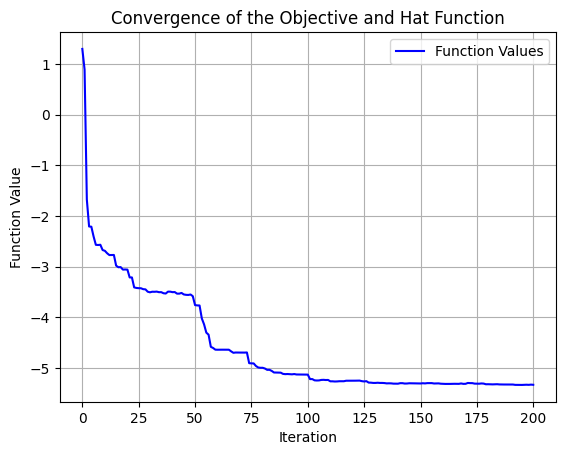

In [27]:

initial_theta  = np.random.rand(num_generators)*2*np.pi

num_iterations=200
sigma = 0.1

best_point, function_values, hat_function_values = oicd(f, generators_dict, initial_theta, num_iterations, sigma,
                             opt_goal='min', 
                             cyclic_mode=False, 
                             subproblem_iter=100,
                             )

import matplotlib.pyplot as plt

# Assuming function_values and hat_function_values are lists or arrays of objective function values
plt.plot(function_values, label='Function Values', color='b')
# plt.plot(hat_function_values, label='Hat Function Values', color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Convergence of the Objective and Hat Function')

# Adding a legend to differentiate the two curves
plt.legend()

# Show grid for easier visualization
plt.grid(True)

# Show the plot
plt.show()


In [55]:
opt_interp_points = [0, np.pi*2/3, np.pi*4/3]

inverse_interp_matrix = np.array([
            [np.sqrt(2)/3, np.sqrt(2)/3, np.sqrt(2)/3],
            [2/3, -1/3, -1/3],
            [0, 1/np.sqrt(3), -1/np.sqrt(3)]
            ])

omega_set = [2]

generators_dict = {}

for i in range(dim):
    generators_dict[f"Generator_{i}"] = {
        'opt_interp_points': opt_interp_points,
        'omega_set': omega_set,
        'inverse_interp_matrix': inverse_interp_matrix
    }

NameError: name 'dim' is not defined